In [ ]:
import os
import numpy
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# File Processing

In [3]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        print(f"Processing file: {filepath}")


Processing file: ./dataset\fhvhv_tripdata_2022-01.parquet
Processing file: ./dataset\fhvhv_tripdata_2022-02.parquet


In [4]:
# Loading Data

In [5]:
path_files = []

for year in range(2022, 2025):
    year_files = [files for files in os.listdir('./dataset') if f'_{year}-' in files]
    year_files.sort() 
    
    for file in year_files:
        path_files.append(pandas.read_parquet('./dataset/' + file))
        
print(f"Loaded {len(path_files)} files.")

Loaded 2 files.


In [6]:
df = pandas.concat(path_files, ignore_index=True)
print(f"Total rows: {len(df)}")

Total rows: 30770874


In [7]:
df.columns
df['base_passenger_fare'].describe()

count    3.077087e+07
mean     2.041490e+01
std      1.598893e+01
min     -5.201100e+02
25%      1.029000e+01
50%      1.609000e+01
75%      2.502000e+01
max      4.995960e+03
Name: base_passenger_fare, dtype: float64

In [8]:
# Data Cleaning

In [9]:
df = df[(df['base_passenger_fare'] >= 0) & (df['base_passenger_fare'] < 100)]
print(f"Rows after filtering by fare: {len(df)}")

Rows after filtering by fare: 30589303


In [10]:
df = df[df['airport_fee'] == 0]
print(f"Rows after removing airport fee: {len(df)}")

Rows after removing airport fee: 28799598


In [11]:
df = df[['hvfhs_license_num', 'request_datetime', 'pickup_datetime','dropoff_datetime','trip_miles','trip_time', 'base_passenger_fare', 'tips']]
df.describe()

,request_datetime,pickup_datetime,dropoff_datetime,trip_miles,trip_time,base_passenger_fare,tips
count,28799598,28799598,28799598,2.879960e+07,2.879960e+07,2.879960e+07,2.879960e+07
mean,2022-02-01 05:06:40.889685,2022-02-01 05:11:13.478900,2022-02-01 05:27:50.942393,4.022582e+00,1.000048e+03,1.859486e+01,7.175391e-01
min,2021-12-31 22:55:05,2022-01-01 00:00:00,2022-01-01 00:02:49,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022-01-17 19:52:30,2022-01-17 19:56:07.250000,2022-01-17 20:10:11,1.480000e+00,5.480000e+02,9.970000e+00,0.000000e+00
50%,2022-02-02 08:48:51,2022-02-02 08:54:44,2022-02-02 09:16:13,2.633000e+00,8.450000e+02,1.537000e+01,0.000000e+00
75%,2022-02-15 14:59:04,2022-02-15 15:03:53,2022-02-15 15:22:44,5.045000e+00,1.279000e+03,2.323000e+01,0.000000e+00
max,2022-03-01 00:10:00,2022-02-28 23:59:59,2022-03-01 01:38:23,3.611130e+02,9.915200e+04,9.999000e+01,2.000000e+02
std,NaN,NaN,NaN,4.030963e+00,6.415795e+02,1.176026e+01,2.048696e+00


In [12]:
# Feature Engineering

In [13]:
df['request_hour'] = df['request_datetime'].dt.hour
df['request_day_of_week'] = df['request_datetime'].dt.dayofweek

In [14]:
encoder = LabelEncoder()
df['hvfhs_license_num_encoded'] = encoder.fit_transform(df['hvfhs_license_num'])
df = df.drop(columns=['hvfhs_license_num'])

In [15]:
# Spliting Data (Train, Validation, Test)

In [16]:
train_data = df[df['request_datetime'].dt.day <= 20]

# Validation: Days 21–25
validation_data = df[(df['request_datetime'].dt.day >= 21) & (df['request_datetime'].dt.day <= 25)]

# Test: Days 26–end of the month
test_data = df[df['request_datetime'].dt.day >= 26]

In [17]:
train_data = train_data.drop(columns=['request_datetime', 'pickup_datetime', 'dropoff_datetime'])
validation_data = validation_data.drop(columns=['request_datetime', 'pickup_datetime', 'dropoff_datetime'])
test_data = test_data.drop(columns=['request_datetime', 'pickup_datetime', 'dropoff_datetime'])

In [18]:
# Data Normalization

In [19]:
columns_to_scale = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']

scaler = StandardScaler()

# Training data
train_data_scaled = train_data.copy()
train_data_scaled[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

# Validation data
validation_data_scaled = validation_data.copy()
validation_data_scaled[columns_to_scale] = scaler.transform(validation_data[columns_to_scale])

# Test data
test_data_scaled = test_data.copy()
test_data_scaled[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

In [20]:
print("Train Data Sample:")
print(train_data[:5])

Train Data Sample:
   trip_miles  trip_time  base_passenger_fare  tips  request_hour  \
0        1.18        664                24.90   0.0             0   
1        0.82        460                11.97   0.0             0   
2        1.18        595                29.82   0.0             0   
3        1.65        303                 7.91   0.0             0   
4        1.65        461                 9.44   0.0             0   

   request_day_of_week  hvfhs_license_num_encoded  
0                    5                          0  
1                    5                          0  
2                    5                          0  
3                    5                          0  
4                    5                          0  


In [21]:
print("Validation Data Sample:")
print(validation_data[:2])

Validation Data Sample:
         trip_miles  trip_time  base_passenger_fare  tips  request_hour  \
9149683        4.46        760                17.93   0.0             0   
9149807        2.38        611                12.08   0.0             0   

         request_day_of_week  hvfhs_license_num_encoded  
9149683                    4                          0  
9149807                    4                          0  


In [22]:
df[['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']] = scaler.fit_transform(
    df[['trip_miles', 'trip_time', 'base_passenger_fare', 'tips']]
)


In [23]:
df['hour'] = pandas.to_datetime(df['pickup_datetime']).dt.hour
df['day_of_week'] = pandas.to_datetime(df['pickup_datetime']).dt.dayofweek

In [24]:
target_column = 'base_passenger_fare'

# Extract features and targets
X_train = train_data_scaled.drop(columns=[target_column])
y_train = train_data_scaled[target_column]

X_val = validation_data_scaled.drop(columns=[target_column])
y_val = validation_data_scaled[target_column]

X_test = test_data_scaled.drop(columns=[target_column])
y_test = test_data_scaled[target_column]


In [25]:
# Define the model
model = Sequential([
    # Explicit Input Layer
    Input(shape=(X_train.shape[1],)),

    # First Hidden Layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Second Hidden Layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third Hidden Layer
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output Layer
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1751s 3ms/step - loss: 0.2444 - mae: 0.3203 - val_loss: 0.4241 - val_mae: 0.2553
Epoch 2/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1921s 3ms/step - loss: 0.2266 - mae: 0.3103 - val_loss: 0.5476 - val_mae: 0.2697
Epoch 3/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 2195s 4ms/step - loss: 0.2258 - mae: 0.3099 - val_loss: 0.2837 - val_mae: 0.2793
Epoch 4/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 2278s 4ms/step - loss: 0.2243 - mae: 0.3091 - val_loss: 3.0885 - val_mae: 0.3094
Epoch 5/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 2345s 4ms/step - loss: 0.2242 - mae: 0.3090 - val_loss: 0.4354 - val_mae: 0.2764
Epoch 6/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 2031s 3ms/step - loss: 0.2240 - mae: 0.3088 - val_loss: 0.4771 - val_mae: 0.2900
Epoch 7/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 1967s 3ms/step - loss: 0.2240 - mae: 0.3089 - val_loss: 0.6851 - val_mae: 0.2933
Epoch 8/20
604250/604250 ━━━━━━━━━━━━━━━━━━━━ 2017s 3ms/step - loss: 0.2240 - mae: 0.3089 - val_loss: 0.4208 - 

In [ ]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = numpy.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

139878/139878 ━━━━━━━━━━━━━━━━━━━━ 146s 1ms/step
RMSE: 0.6976405288220727
MAE: 0.38325424579034323


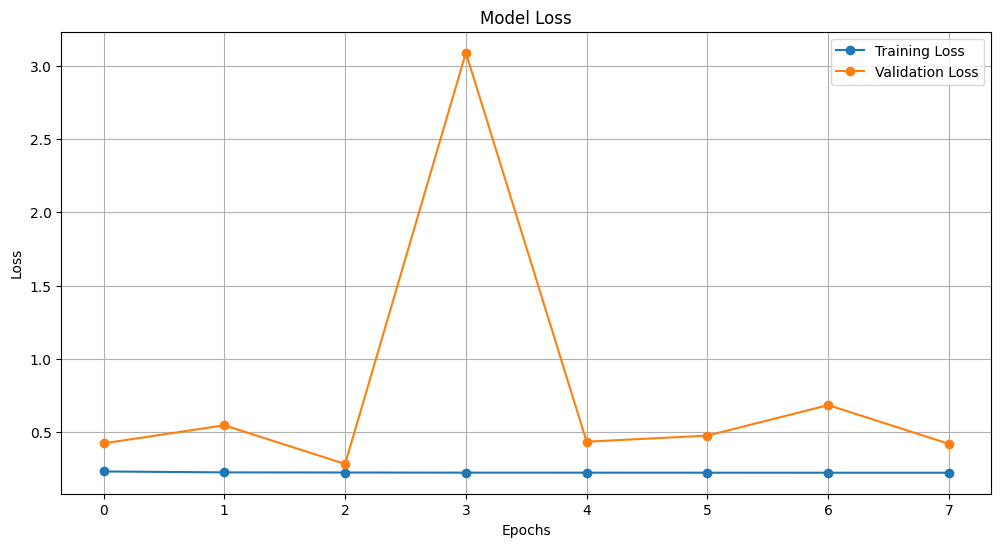

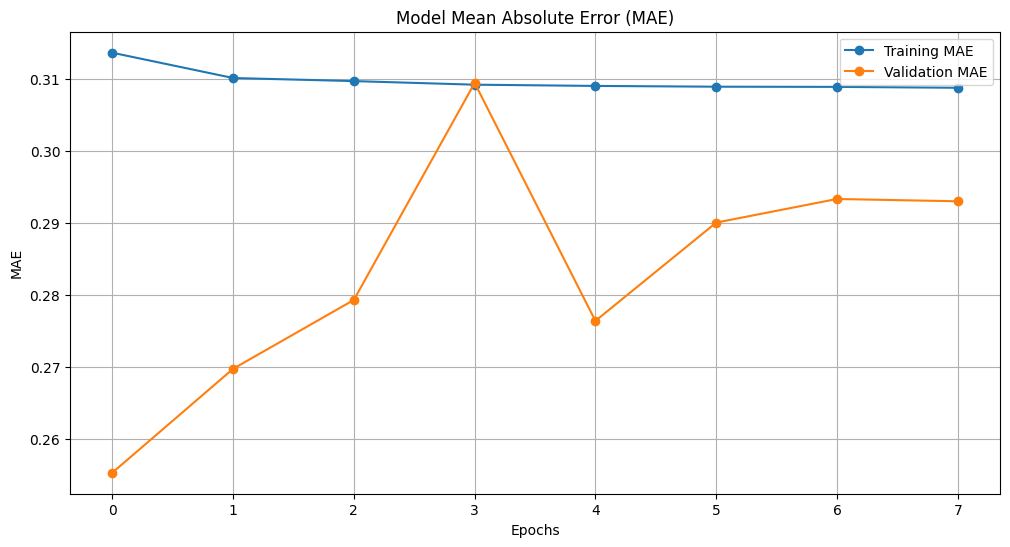

In [ ]:
# Evaluate Model and Plot Training History

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

101102/101102 ━━━━━━━━━━━━━━━━━━━━ 103s 1ms/step
Uber (HV0003) - RMSE: 0.65, MAE: 0.36


C:\Users\Anshi Singh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


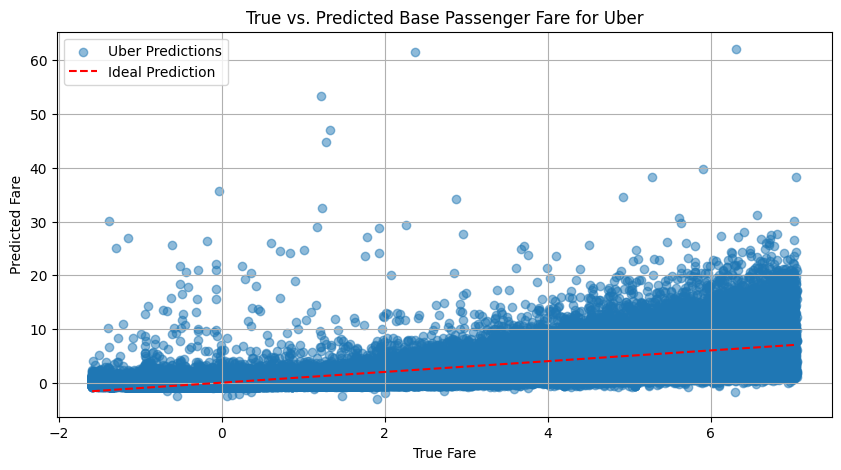

38777/38777 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step
Lyft (HV0005) - RMSE: 0.82, MAE: 0.44


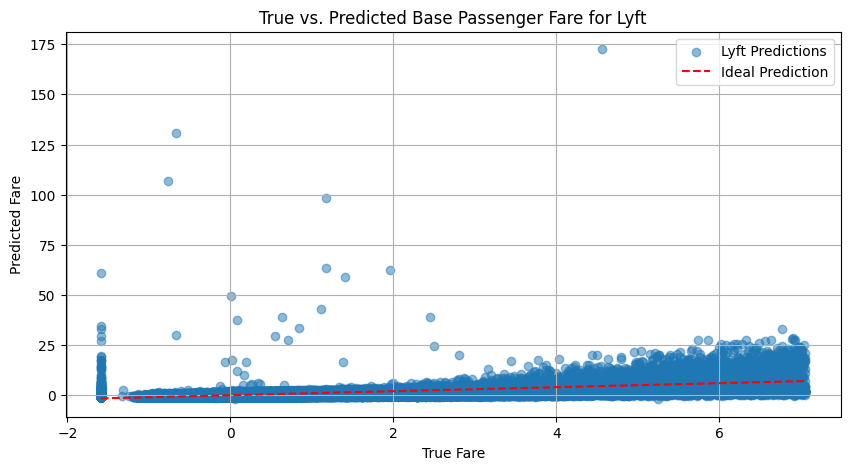

In [33]:
# Compare Predictions For Specific Liscence Plates
license_plates = {'HV0003': 'Uber', 'HV0005': 'Lyft'}

for plate, company in license_plates.items():
    group_data = test_data_scaled[test_data_scaled['hvfhs_license_num_encoded'] == encoder.transform([plate])[0]]
    X_group = group_data.drop(columns=[target_column])
    y_group_true = group_data[target_column]
    
    y_group_pred = model.predict(X_group)
    
    # Compute metrics for this group
    group_rmse = numpy.sqrt(mean_squared_error(y_group_true, y_group_pred))
    group_mae = mean_absolute_error(y_group_true, y_group_pred)
    
    print(f"{company} ({plate}) - RMSE: {group_rmse:.2f}, MAE: {group_mae:.2f}")
    
    # Plot true vs. predicted fares
    plt.figure(figsize=(10, 5))
    plt.scatter(y_group_true, y_group_pred, alpha=0.5, label=f"{company} Predictions")
    plt.plot([y_group_true.min(), y_group_true.max()], [y_group_true.min(), y_group_true.max()], 'r--', label='Ideal Prediction')
    plt.title(f"True vs. Predicted Base Passenger Fare for {company}")
    plt.xlabel('True Fare')
    plt.ylabel('Predicted Fare')
    plt.legend()
    plt.grid(True)
    plt.show()

101102/101102 ━━━━━━━━━━━━━━━━━━━━ 112s 1ms/step
38777/38777 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step


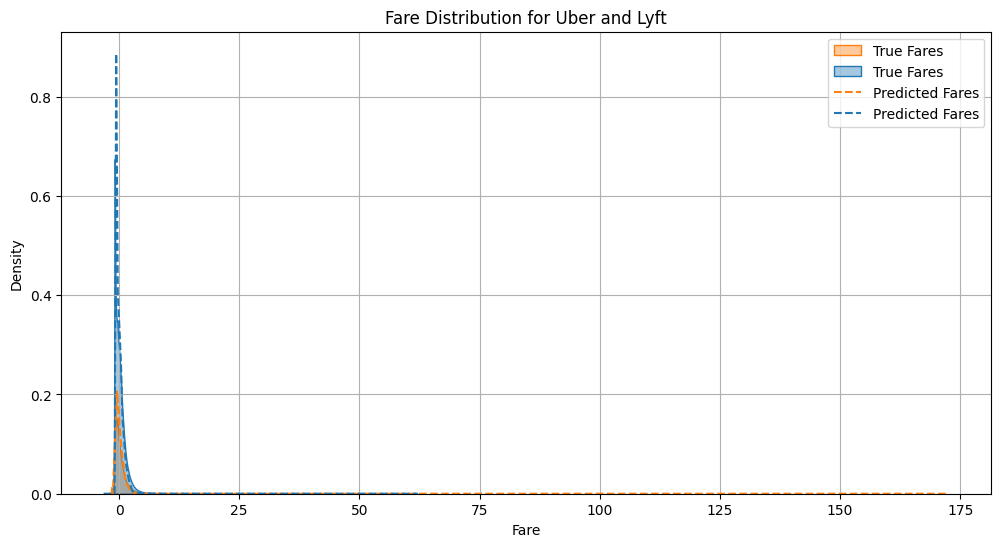

In [37]:
# Price Difference Visualization

# Combine predictions into a single DataFrame
all_predictions = []
for plate, company in license_plates.items():
    group_data = test_data_scaled[test_data_scaled['hvfhs_license_num_encoded'] == encoder.transform([plate])[0]]
    X_group = group_data.drop(columns=[target_column])
    y_group_true = group_data[target_column]
    y_group_pred = model.predict(X_group).flatten()
    
    temp_df = pandas.DataFrame({
        'Company': company,
        'True Fare': y_group_true,
        'Predicted Fare': y_group_pred
    })
    all_predictions.append(temp_df)

all_predictions = pandas.concat(all_predictions, ignore_index=True)

# Plot distribution
plt.figure(figsize=(12, 6))
sns.kdeplot(data=all_predictions, x='True Fare', hue='Company', label='True Fares', fill=True, alpha=0.4)
sns.kdeplot(data=all_predictions, x='Predicted Fare', hue='Company', linestyle='--', label='Predicted Fares')
plt.title('Fare Distribution for Uber and Lyft')
plt.xlabel('Fare')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
print(test_data.columns)


Index(['trip_miles', 'trip_time', 'base_passenger_fare', 'tips',
       'request_hour', 'request_day_of_week', 'hvfhs_license_num_encoded'],
      dtype='object')


28762/28762 ━━━━━━━━━━━━━━━━━━━━ 28s 956us/step
14660/14660 ━━━━━━━━━━━━━━━━━━━━ 14s 974us/step
15329/15329 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
17443/17443 ━━━━━━━━━━━━━━━━━━━━ 17s 998us/step
31832/31832 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
31855/31855 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step


C:\Users\Anshi Singh\AppData\Local\Temp\ipykernel_18556\3275291631.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_of_week_rmse = test_data_scaled.groupby('request_day_of_week').apply(


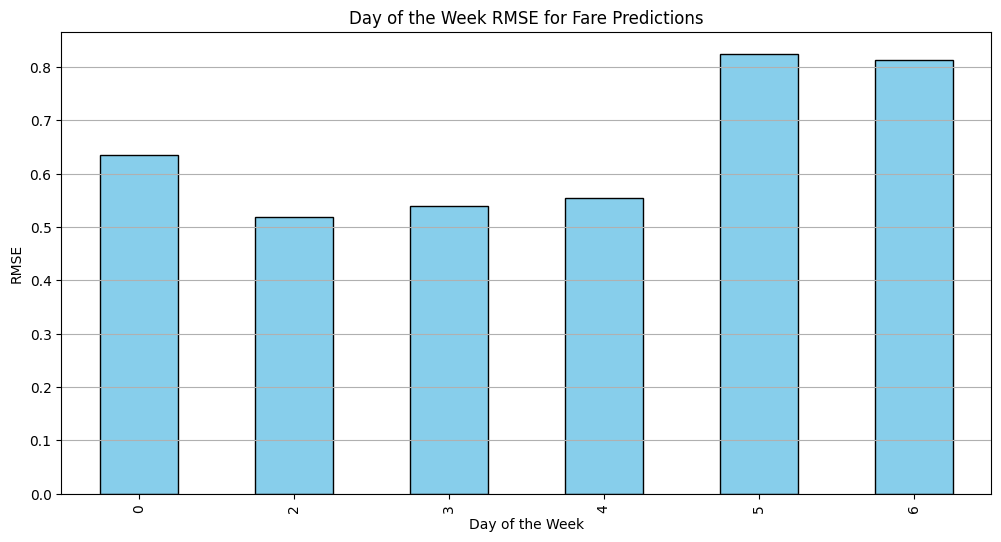

In [43]:
# Evaluate Accuracy by Day of the Week

test_data_scaled['request_day_of_week'] = test_data['request_day_of_week']

# Group by day of the week and compute average RMSE
day_of_week_rmse = test_data_scaled.groupby('request_day_of_week').apply(
    lambda group: numpy.sqrt(mean_squared_error(group[target_column], model.predict(group.drop(columns=[target_column]))))
)

# Plot hourly RMSE
plt.figure(figsize=(12, 6))
day_of_week_rmse.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Day of the Week RMSE for Fare Predictions')
plt.xlabel('Day of the Week')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()

5570/5570 ━━━━━━━━━━━━━━━━━━━━ 4s 763us/step
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3080/3080 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
5566/5566 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6434/6434 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
5895/5895 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
5684/5684 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5759/5759 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
5903/5903 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6209/6209 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6865/6865 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7008/7008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7239/7239 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
8151/8151 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
8941/8941 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
8729/8729 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
7871/7871 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7483/7483 ━━━━━━━━━━━━━━━━━━━━ 5s 732us/step
7402/7402 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

C:\Users\Anshi Singh\AppData\Local\Temp\ipykernel_18556\3770852274.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_rmse = test_data_scaled.groupby('request_hour').apply(


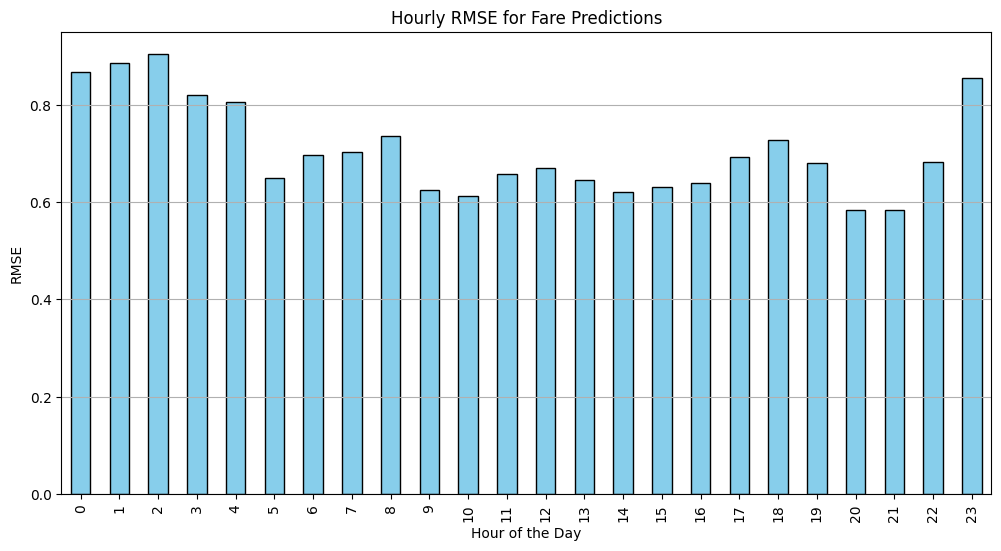

In [41]:
# Evaluate Accuracy by Hour

test_data_scaled['request_hour'] = test_data['request_hour']

# Group by hour and compute average RMSE
hourly_rmse = test_data_scaled.groupby('request_hour').apply(
    lambda group: numpy.sqrt(mean_squared_error(group[target_column], model.predict(group.drop(columns=[target_column]))))
)

# Plot hourly RMSE
plt.figure(figsize=(12, 6))
hourly_rmse.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Hourly RMSE for Fare Predictions')
plt.xlabel('Hour of the Day')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()